# **Lab3 : Image Segmentation (Histogram of Oriented Gradients & K-Mean Clustering)**

In [12]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import measure
import glob
from sklearn.cluster import KMeans
from scipy import spatial
from tqdm import tqdm
import cv2
import os 
import random

## Load Image

Image shape: 750x750 pixels


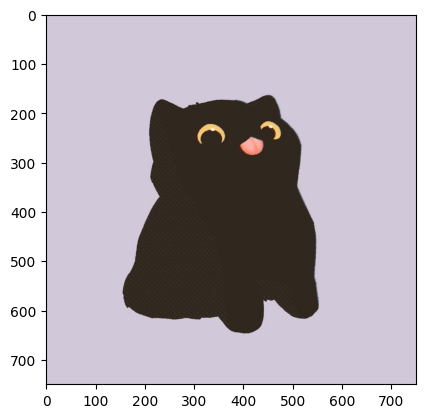

In [13]:
### START CODE HERE ###
img = cv2.imread("./images/image-01.jpg")
h, w, _ = img.shape
print(f"Image shape: {h}x{w} pixels")
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_img)
### END CODE HERE ###

## Histogram of Oriented Gradients

Blur the image then apply to the [`hog()`](<https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.hog:~:text=skimage.feature.hog(,%23>)
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/refs/heads/main/Lab3_Image-Segmentation/asset/1.png?raw=true)
</details>

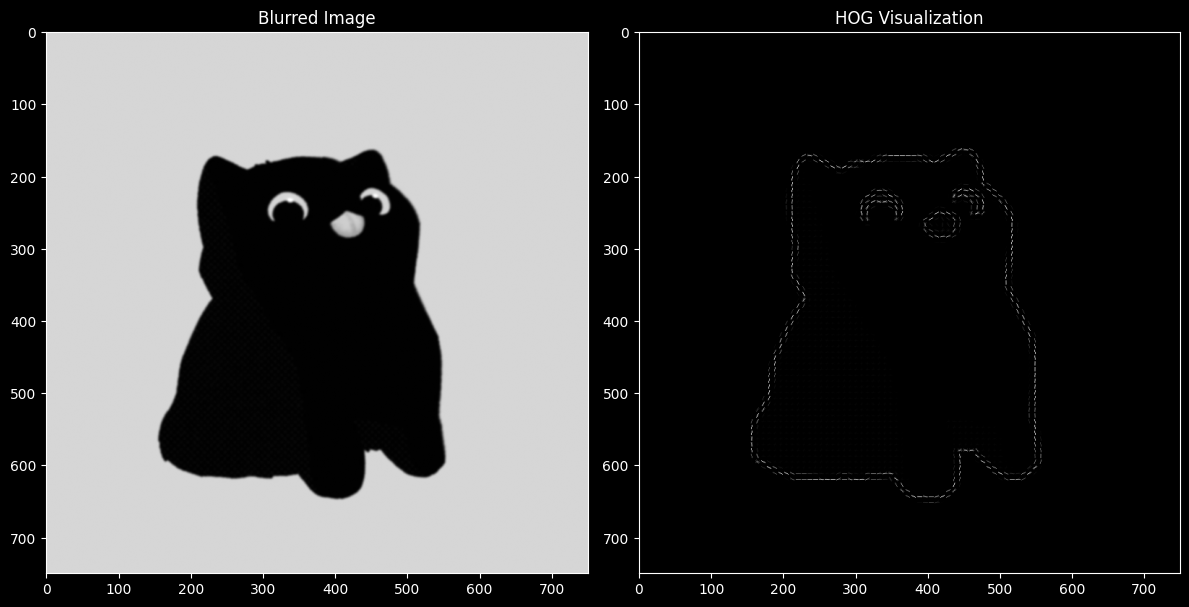

In [14]:
### START CODE HERE ###
gray_image = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY)
blurry_image = cv2.GaussianBlur(gray_image, (7, 7), 0)

fd, hog_image = hog(blurry_image, 
                    orientations=9, 
                    pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), 
                    visualize=True, 
                    block_norm='L2-Hys')

plt.style.use('dark_background')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.patch.set_facecolor('black')

ax1.imshow(blurry_image, cmap='gray')
ax1.set_title('Blurred Image', color='white')
ax1.set_facecolor('black')

ax2.imshow(hog_image, cmap='gray')
ax2.set_title('HOG Visualization', color='white')
ax2.set_facecolor('black')

plt.tight_layout()
plt.show()

plt.style.use('default')
### END CODE HERE ###

Complete the `HOGSubimageExtractor()`.

That extracts Histogram of Oriented Gradients features from sub-images of a larger image. It divides the image into overlapping tiles, computes HOG features for each tile, and stores both the feature vectors and visualizations. The class also provides a method to plot the HOG visualizations.

**Attributes:**
- `image`: The input image.
- `tile_size`: The size of each sub-image to extract.
- `stride`: The pixel stride between consecutive sub-images.
- `hGrid`: An array of indices representing the starting positions for rows of sub-images.
- `wGrid`: An array of indices representing the starting positions for columns of sub-images.
- `hog_features`: A list to store the HOG feature vectors for each sub-image.
- `hog_images`: A list to store the visualized HOG images for each sub-image (optional).

**Methods:**
- `extract_hog_features()`: Compute HOG features for each sub-image.
- `plot_hog_images()`: Plots the HOG visualization images.
- `get_num_grid()`: Return the number of rows and columns in the grid of sub-images.


In [15]:
### START CODE HERE ###
class HOGSubimageExtractor:
    def __init__(self, image, tile_size, stride, pixel_side=8, cell_side=2):
        self.image = image
        self.tile_size = tile_size
        self.stride = stride
        self.h, self.w, _ = image.shape
        self.pixel_side = pixel_side
        self.cell_side = cell_side
        
        self.hGrid = np.arange(0, self.h - tile_size + 1, stride)
        self.wGrid = np.arange(0, self.w - tile_size + 1, stride)
        
        self.hog_features = []
        self.hog_images = []
        self.extract_hog_features()

    def extract_hog_features(self):
        for h_start in self.hGrid:
            for w_start in self.wGrid:
                tile = self.image[h_start:h_start + self.tile_size, 
                                w_start:w_start + self.tile_size]
                
                if len(tile.shape) == 3:
                    tile_gray = cv2.cvtColor(tile, cv2.COLOR_RGB2GRAY)
                else:
                    tile_gray = tile
                
                fd, hog_img = hog(tile_gray, 
                                orientations=9, 
                                pixels_per_cell=(self.pixel_side, self.pixel_side),
                                cells_per_block=(self.cell_side, self.cell_side), 
                                visualize=True, 
                                block_norm='L2-Hys')
                
                self.hog_features.append(fd)
                self.hog_images.append(hog_img)

    def plot_hog_images(self):
        num_h, num_w = self.get_num_grid()
        
        plt.style.use('dark_background')
        
        fig, axes = plt.subplots(num_h, num_w, figsize=(num_w * 2, num_h * 2))
        fig.patch.set_facecolor('black')
        
        if num_h == 1:
            axes = axes.reshape(1, -1)
        if num_w == 1:
            axes = axes.reshape(-1, 1)
            
        idx = 0
        for i in range(num_h):
            for j in range(num_w):
                if idx < len(self.hog_images):
                    axes[i, j].imshow(self.hog_images[idx], cmap='gray')
                    axes[i, j].set_facecolor('black')
                    axes[i, j].axis('off')
                    idx += 1
                else:
                    axes[i, j].set_facecolor('black')
                    axes[i, j].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        plt.style.use('default')

    def get_num_grid(self):
        return len(self.hGrid), len(self.wGrid)
### END CODE HERE ###


Let's use `HOGSubimageExtractor()` in the cell below.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output from hog_extractor.plot_hog_images()</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/refs/heads/main/Lab3_Image-Segmentation/asset/2.png)
</details>

Number of grids: (22, 22)


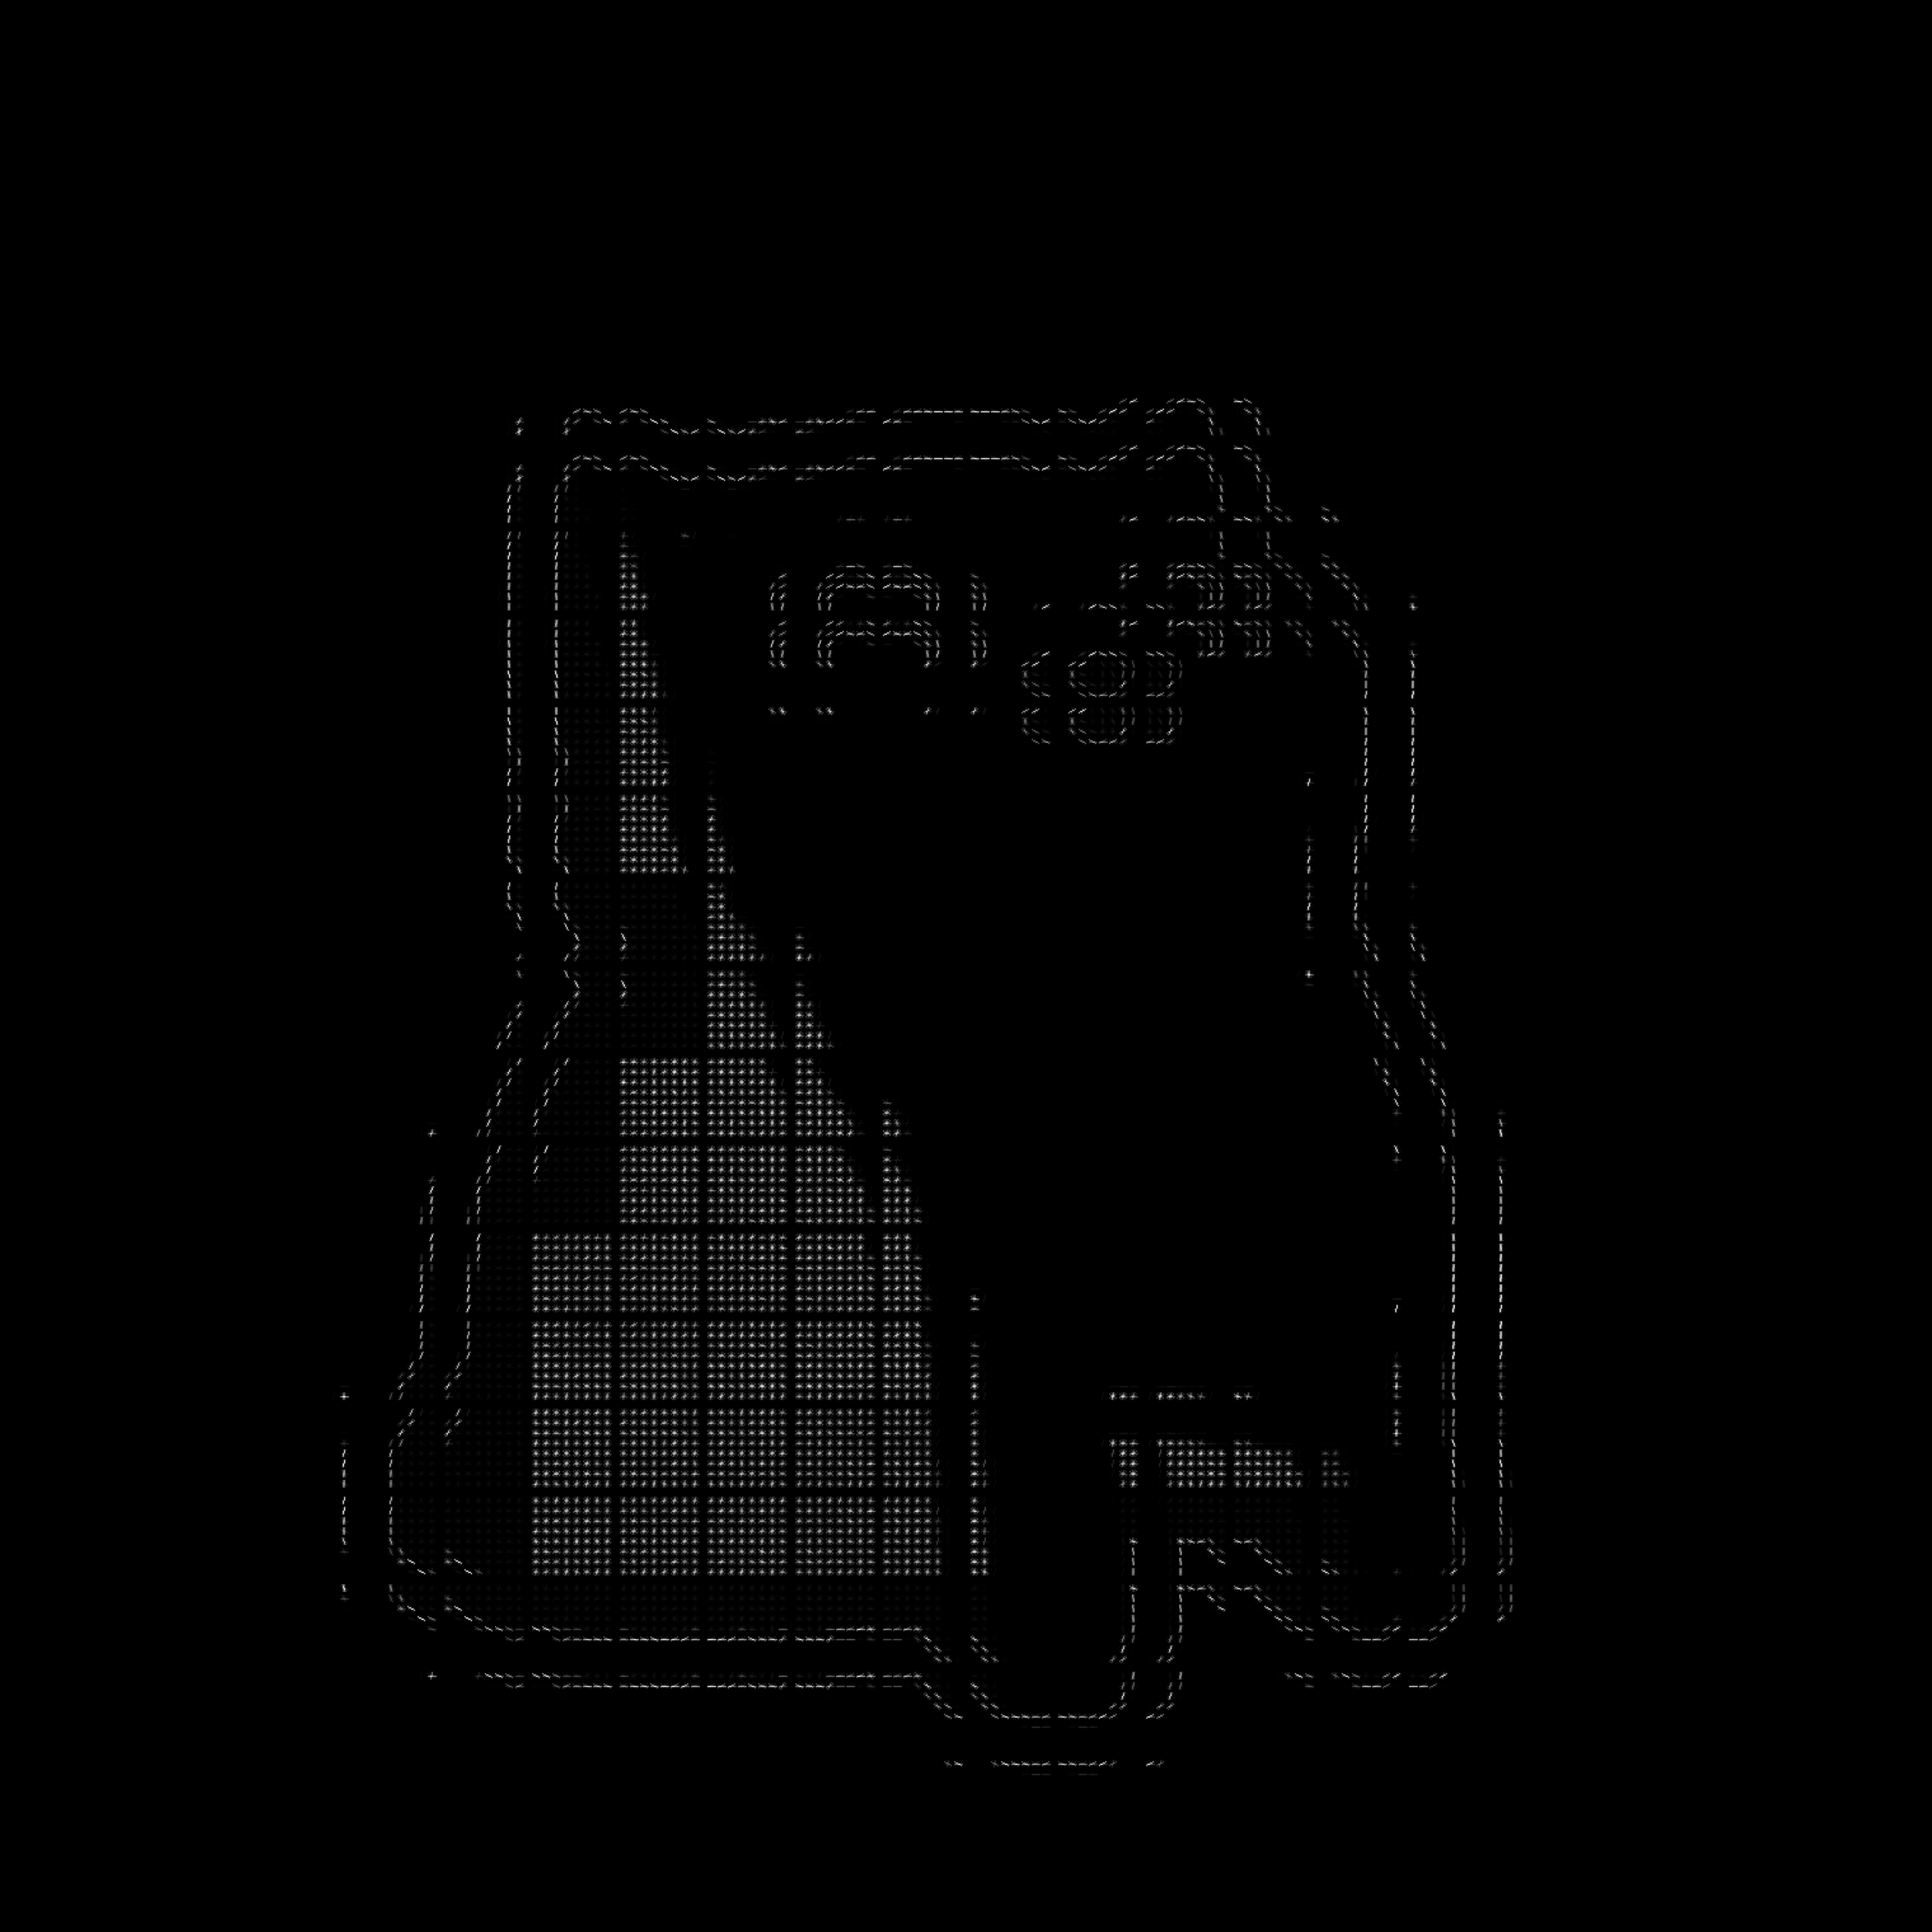

In [16]:
### START CODE HERE ###
tile_size = 64
stride = 32
pixel_side = 8
cell_side = 2
hog_extractor = HOGSubimageExtractor(rgb_img, tile_size, stride, pixel_side, cell_side)
num_grid = hog_extractor.get_num_grid()
print(f'Number of grids: {num_grid}')
hog_extractor.plot_hog_images()
### END CODE HERE ###

## K-Mean Clustering
Complete the `KMeansCluster()`.
Perform K-means clustering on Histogram of Oriented Gradients (HOG) features extracted from an image.
**Attriburtes:**
- `hog_extractor`: An object responsible for extractin HOG features from an image.
- `n_clusters`: The number of clusters to use in K-means.
- `cluster_array`: A 2D array representing the cluster assignments for each grid cell.
- `all_labels`: A 2D array representing the connected components (objects) identified after clustering.
- `bounding_boxes`: A list of tuples containing (object_id, start_coordinates, end_coordinates) for each detected object.

**Method:**
- `perform_clustering()`: Performs K-means clustering on the HOG features extracted by the hog_extractor object.<br>
It then reshapes the cluster assignmentss into a grid and identifies connected components using the `measure.label()` function.
- `plot_cluster_and_labels()`: Visualize the cluster assignments and connected components as images using Matplotlib.
- `get_bounding_boxes()`: Extracts bounding boxes for each detected object.

In [17]:
### START CODE HERE ###
class KMeansCluster:
    def __init__(self, hog_extractor, n_clusters=3, random_state=42):
        self.hog_extractor = hog_extractor
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.cluster_array = None
        self.all_labels = None
        self.bounding_boxes = []
        self.perform_clustering()

    def perform_clustering(self):
        # Get HOG features from the extractor
        features = np.array(self.hog_extractor.hog_features)
        
        # Perform K-means clustering
        kmeans = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)
        cluster_labels = kmeans.fit_predict(features)
        
        # Get grid dimensions
        num_h, num_w = self.hog_extractor.get_num_grid()
        
        # Reshape cluster assignments into grid
        self.cluster_array = cluster_labels.reshape(num_h, num_w)
        
        # Identify connected components
        self.all_labels = measure.label(self.cluster_array)

    def plot_cluster_and_labels(self):
        # Set dark background style
        plt.style.use('dark_background')
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        fig.patch.set_facecolor('black')
        
        # Plot cluster assignments
        im1 = ax1.imshow(self.cluster_array, cmap='tab10')
        ax1.set_title('Cluster Assignments', color='white')
        ax1.set_facecolor('black')
        ax1.axis('off')
        
        # Plot connected components (labels)
        im2 = ax2.imshow(self.all_labels, cmap='nipy_spectral')
        ax2.set_title('Connected Components', color='white')
        ax2.set_facecolor('black')
        ax2.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Reset to default style
        plt.style.use('default')

    def get_bounding_boxes(self):
        self.bounding_boxes = []
        
        # Get unique labels (excluding background label 0)
        unique_labels = np.unique(self.all_labels)
        unique_labels = unique_labels[unique_labels != 0]
        
        for label in unique_labels:
            # Find pixels belonging to this label
            mask = self.all_labels == label
            
            # Get coordinates of pixels in this component
            coords = np.where(mask)
            
            if len(coords[0]) > 0:
                # Calculate bounding box coordinates
                min_row, max_row = np.min(coords[0]), np.max(coords[0])
                min_col, max_col = np.min(coords[1]), np.max(coords[1])
                
                # Convert grid coordinates to image coordinates
                tile_size = self.hog_extractor.tile_size
                stride = self.hog_extractor.stride
                
                # Calculate actual image coordinates
                start_y = min_row * stride
                end_y = max_row * stride + tile_size
                start_x = min_col * stride
                end_x = max_col * stride + tile_size
                
                # Store bounding box: (object_id, start_coordinates, end_coordinates)
                bbox = (label, (start_x, start_y), (end_x, end_y))
                self.bounding_boxes.append(bbox)
        
        return self.bounding_boxes
### END CODE HERE ###

Complete the function below. Using [`cv2.rectangle()`](<https://docs.opencv.org/4.x/dc/da5/tutorial_py_drawing_functions.html#:~:text=511%2C511)%2C(255%2C0%2C0)%2C5)-,Drawing%20Rectangle,-To%20draw%20a>)

In [18]:
### START CODE HERE ###
def draw_bbox(image, bboxes):
    img_with_bbox = image.copy()
    
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), 
              (255, 0, 255), (0, 255, 255), (128, 0, 128), (255, 165, 0)]
    
    for i, bbox in enumerate(bboxes):
        object_id, start_coord, end_coord = bbox
        start_x, start_y = start_coord
        end_x, end_y = end_coord
        
        color = colors[i % len(colors)]
        
        cv2.rectangle(img_with_bbox, (start_x, start_y), (end_x, end_y), color, 2)

    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(img_with_bbox, cv2.COLOR_BGR2RGB))
    plt.title('Object Detection with Bounding Boxes')
    plt.axis('off')
    plt.show()
    
    return img_with_bbox
### END CODE HERE ###

Let's use `KMeansCluster()` and `draw_bbox()` in the cell below.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image-3.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/refs/heads/main/Lab3_Image-Segmentation/asset/3.png?raw=true)

![image-4.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/refs/heads/main/Lab3_Image-Segmentation/asset/4.png?raw=true)
</details>

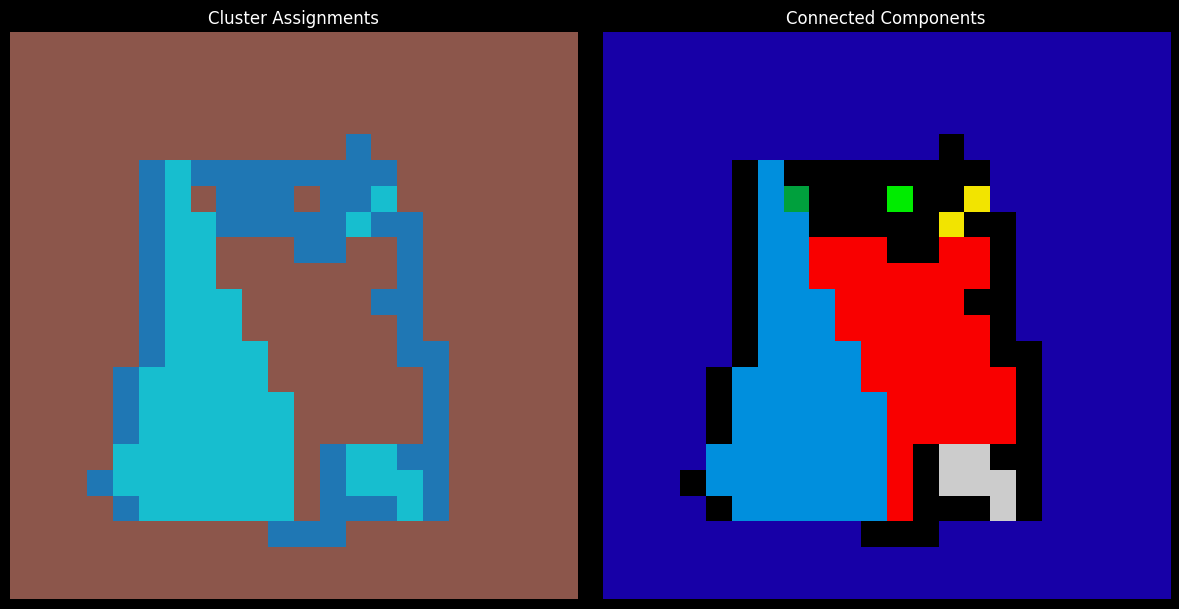

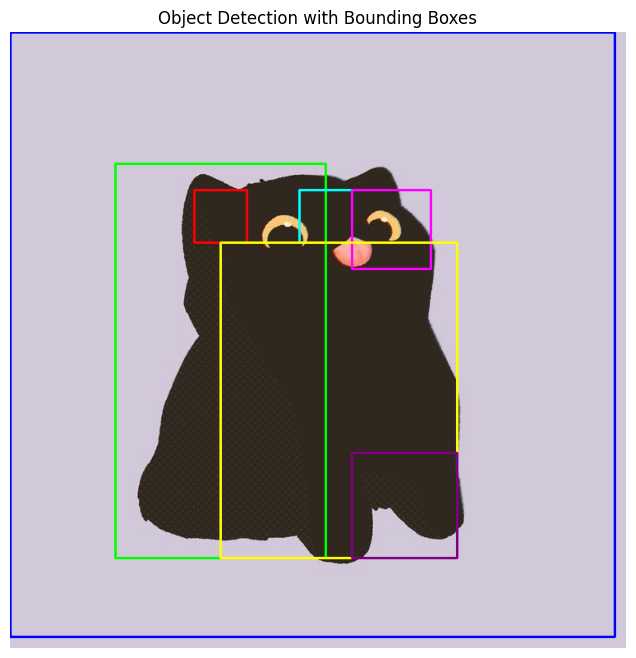

array([[[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [217, 200, 209],
        [217, 200, 209],
        [217, 200, 209]],

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [217, 200, 209],
        [217, 200, 209],
        [217, 200, 209]],

       [[255,   0,   0],
        [255,   0,   0],
        [217, 200, 209],
        ...,
        [217, 200, 209],
        [217, 200, 209],
        [217, 200, 209]],

       ...,

       [[217, 200, 209],
        [217, 200, 209],
        [217, 200, 209],
        ...,
        [217, 200, 209],
        [217, 200, 209],
        [217, 200, 209]],

       [[217, 200, 209],
        [217, 200, 209],
        [217, 200, 209],
        ...,
        [217, 200, 209],
        [217, 200, 209],
        [217, 200, 209]],

       [[217, 200, 209],
        [217, 200, 209],
        [217, 200, 209],
        ...,
        [217, 200, 209],
        [217, 200, 209],
        [217, 200, 209]]

In [19]:
kmeans_cluster = KMeansCluster(hog_extractor, n_clusters=3, random_state=42)
kmeans_cluster.plot_cluster_and_labels()
bboxes = kmeans_cluster.get_bounding_boxes()
draw_bbox(img, bboxes)

---

## Experiment
Do the experiment to identify 3 best parameters that produce the perfectly fitting bounding box of the object of interest in the image.

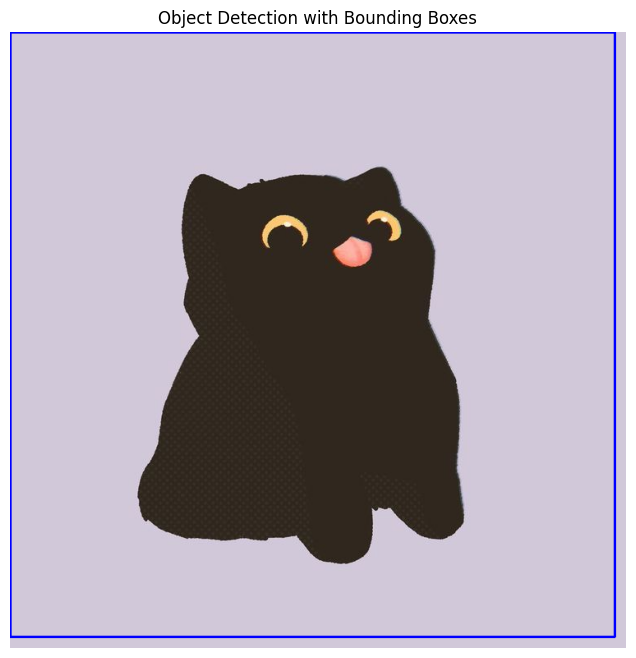

array([[[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [217, 200, 209],
        [217, 200, 209],
        [217, 200, 209]],

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [217, 200, 209],
        [217, 200, 209],
        [217, 200, 209]],

       [[255,   0,   0],
        [255,   0,   0],
        [217, 200, 209],
        ...,
        [217, 200, 209],
        [217, 200, 209],
        [217, 200, 209]],

       ...,

       [[217, 200, 209],
        [217, 200, 209],
        [217, 200, 209],
        ...,
        [217, 200, 209],
        [217, 200, 209],
        [217, 200, 209]],

       [[217, 200, 209],
        [217, 200, 209],
        [217, 200, 209],
        ...,
        [217, 200, 209],
        [217, 200, 209],
        [217, 200, 209]],

       [[217, 200, 209],
        [217, 200, 209],
        [217, 200, 209],
        ...,
        [217, 200, 209],
        [217, 200, 209],
        [217, 200, 209]]

In [20]:
### START CODE HERE ###
tile_size = 64
stride = 32
pixel_side = 8
cell_side = 2

hog_extractor01 = HOGSubimageExtractor(rgb_img, tile_size, stride, pixel_side, cell_side)
# hog_extractor01.plot_hog_images()

kmeans_cluster01 = KMeansCluster(hog_extractor01, n_clusters=2, random_state=42)
# kmeans_cluster01.plot_cluster_and_labels()
bboxes01 = kmeans_cluster01.get_bounding_boxes()
draw_bbox(img, bboxes01)
### END CODE HERE ###

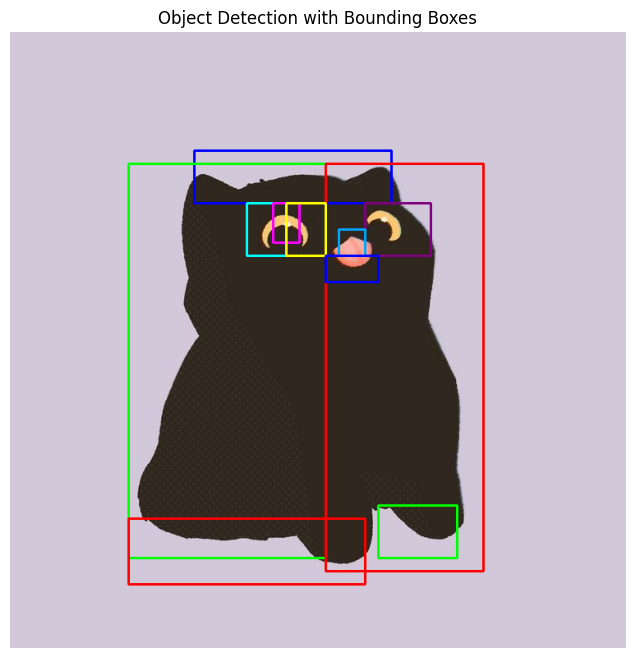

array([[[217, 200, 209],
        [217, 200, 209],
        [217, 200, 209],
        ...,
        [217, 200, 209],
        [217, 200, 209],
        [217, 200, 209]],

       [[217, 200, 209],
        [217, 200, 209],
        [217, 200, 209],
        ...,
        [217, 200, 209],
        [217, 200, 209],
        [217, 200, 209]],

       [[217, 200, 209],
        [217, 200, 209],
        [217, 200, 209],
        ...,
        [217, 200, 209],
        [217, 200, 209],
        [217, 200, 209]],

       ...,

       [[217, 200, 209],
        [217, 200, 209],
        [217, 200, 209],
        ...,
        [217, 200, 209],
        [217, 200, 209],
        [217, 200, 209]],

       [[217, 200, 209],
        [217, 200, 209],
        [217, 200, 209],
        ...,
        [217, 200, 209],
        [217, 200, 209],
        [217, 200, 209]],

       [[217, 200, 209],
        [217, 200, 209],
        [217, 200, 209],
        ...,
        [217, 200, 209],
        [217, 200, 209],
        [217, 200, 209]]

In [21]:
### START CODE HERE ###
tile_size = 32
stride = 16

hog_extractor02 = HOGSubimageExtractor(rgb_img, tile_size, stride)
# hog_extractor01.plot_hog_images()

kmeans_cluster02 = KMeansCluster(hog_extractor02, n_clusters=3, random_state=42)
# kmeans_cluster01.plot_cluster_and_labels()
bboxes02= kmeans_cluster02.get_bounding_boxes()
draw_bbox(img, bboxes02)
### END CODE HERE ###

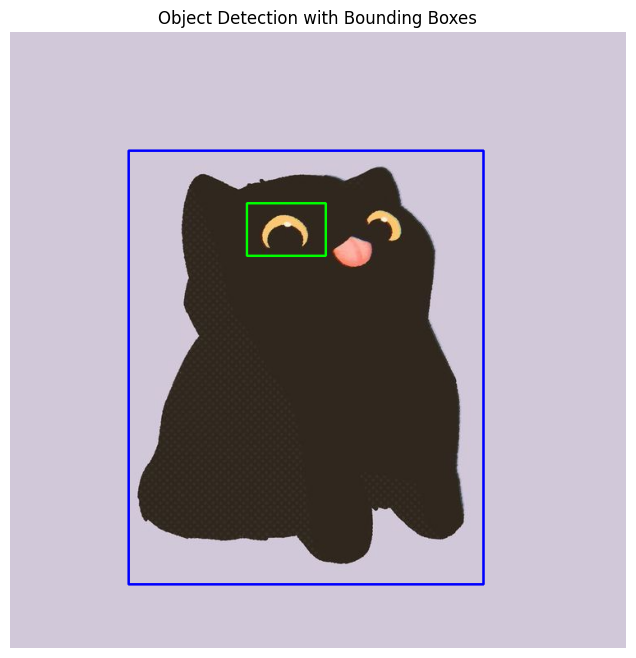

array([[[217, 200, 209],
        [217, 200, 209],
        [217, 200, 209],
        ...,
        [217, 200, 209],
        [217, 200, 209],
        [217, 200, 209]],

       [[217, 200, 209],
        [217, 200, 209],
        [217, 200, 209],
        ...,
        [217, 200, 209],
        [217, 200, 209],
        [217, 200, 209]],

       [[217, 200, 209],
        [217, 200, 209],
        [217, 200, 209],
        ...,
        [217, 200, 209],
        [217, 200, 209],
        [217, 200, 209]],

       ...,

       [[217, 200, 209],
        [217, 200, 209],
        [217, 200, 209],
        ...,
        [217, 200, 209],
        [217, 200, 209],
        [217, 200, 209]],

       [[217, 200, 209],
        [217, 200, 209],
        [217, 200, 209],
        ...,
        [217, 200, 209],
        [217, 200, 209],
        [217, 200, 209]],

       [[217, 200, 209],
        [217, 200, 209],
        [217, 200, 209],
        ...,
        [217, 200, 209],
        [217, 200, 209],
        [217, 200, 209]]

In [22]:
### START CODE HERE ###
tile_size = 32
stride = 16

hog_extractor03 = HOGSubimageExtractor(rgb_img, tile_size, stride)
# hog_extractor01.plot_hog_images()

kmeans_cluster03 = KMeansCluster(hog_extractor03, n_clusters=2, random_state=42)
# kmeans_cluster01.plot_cluster_and_labels()
bboxes03 = kmeans_cluster03.get_bounding_boxes()
draw_bbox(img, bboxes03)
### END CODE HERE ###

---

## **Question** 
1. How do the parameters of Gaussian blur, such as kernel size and standard deviation, affect the image processing in the context of k-means clustering?

2. How do the configurations of cells per block and pixels per cell influence the effectiveness of object detection in an image?

3. What differences can be observed in the clustering results when using smaller sub-images (tiles) compared to larger ones?

4. What is the impact on object detection if the labeling step is skipped before applying k-means clustering?

5. How does the choice of the number of clusters (K) in k-means clustering affect the image clustering result (right) of an input image (left)? 
Discuss the trade-offs between too few and too many clusters in accurately representing the test patterns.<br>

![q5.jpg](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/refs/heads/main/Lab3_Image-Segmentation/asset/q5.jpg?raw=true)
